In [107]:
#This program loads data from 4 different classes
#good, bad, human, maybe

#And uses 5 different acoustic indices on num_spec recordings from each
#1. ACI 2. ADI 3. ADI_even 4. SH 5. NDSI

#Each recording is exactly 2 s long

#Final result: a scatter plot for each acoustic index + scatterplot matrix - pandas

#Spectrograms used: original+4 differential channels

#Note: ACI implementation is not vectorized here to deal with divide by zero error.

In [108]:
#imports
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import hilbert
from scipy.signal import stft
import librosa
import os

#for scatter matrix
import pandas as pd
from pandas.plotting import scatter_matrix

#setting eps value for converting spec to log
eps = 1e-10

#function definitions for acoustic indices begin here


In [109]:
#1. ACI
def compute_aci(specs, time_steps, freq_bins, num_specs):
      
    #Function computes Acoustic Complexity Index
    #According to:
    #http://www.iinsteco.org/people/pubblications/almo/2011/2011_A_new%20methodology_to_infer_the_singing_activity.pdf
      
    abs_diff = np.abs(specs[:, :, 1:] - specs[:, :, 0:time_steps-1])
    
    #accounting for divide by zero
    row_sum = np.sum(specs, axis = 2)
    abs_sum = np.sum(abs_diff, axis = 2)
    ACI = np.zeros((num_specs, 1))
    
    for j in range(num_specs):
        for i in range(freq_bins):
            if(row_sum[j, i]!=0):
                ACI[j] = ACI[j] + abs_sum[j,i]/row_sum[j,i]
    
    return ACI

In [110]:
#2. Acoustic diversity
def compute_adi(specs, time_steps):

    #Function computes Acoustic Diversity Index
    #According to:
    #Pekin (2012)
    #except 70 frequency points have been grouped into 7 bins 
    
    ADI_bins = np.zeros((7,1))
    ADI_bins_norm = np.zeros((7,1))
    
    ADI_all = 0
    
    for i in range(7):      
        
        #for loop for all time steps in same freq bin - sum each row
        start = i
        stop = i+10
        
        ADI_bins[i] = np.sum(specs[start:stop, :])
        
        #print(ADI_bins[i])
       
        
    #normalization
    ADI_bins_norm = ADI_bins/np.sum(ADI_bins)
    ADI_all = 0
    for i in range(7):  
        if(ADI_bins_norm[i]!=0):
            ADI_all = ADI_all + ADI_bins_norm[i] * np.log(ADI_bins_norm[i])
            
        
    return ADI_all


In [111]:
#Helper function for compute_adi_even
def get_start_stop_indices(freq_bins, multiples=1000, num_bins=8):
    
    #find the frequency index numbers to group in bins of 1kHz width from 0-1 kHz, 1-2, till 7-8kHz
    stop_freq_idx = np.zeros((num_bins, 1))
    start_freq_idx = np.zeros((num_bins,1))

    for i in range(num_bins):
        stop_freq = multiples*(i+1)
        #to find the index to clip
        stop_freq_idx[i] = freq_bins.searchsorted(stop_freq, side='right') - 1
        if (i<num_bins-1):
            start_freq_idx[i+1] = stop_freq_idx[i]+1
        
    return start_freq_idx, stop_freq_idx
        

In [112]:
#3. Acoustic diversity with evenly spaced bins
def compute_adi_even(num_bins, specs, freq_vals, start_indices, stop_indices):

    #Function computes Acoustic Diversity Index
    #According to:
    #Pekin (2012)
  
    ADI_bins = np.zeros((num_bins, 1))
    ADI_bins_norm = np.zeros((num_bins,1))
    
    ADI_all = 0
    
    for i in range(num_bins):      
    
        #for loop for all time steps in same freq bin - sum each row
        start = int(start_indices[i])
        stop = int(stop_indices[i])
        ADI_bins[i] = np.sum(specs[start:stop, :])
        #print(ADI_bins[i])
       
        
    #normalization
    ADI_bins_norm = ADI_bins/np.sum(ADI_bins)
    ADI_all = 0
    for i in range(num_bins):  
        if(ADI_bins_norm[i]!=0):
            ADI_all = ADI_all + (ADI_bins_norm[i] * np.log(ADI_bins_norm[i]))
   
    return ADI_all

In [113]:
#4. Spectral entropy 
def compute_sh(spec, time_steps, freq_bin):
    
    #This function is a modified version of  spectral entropy as described in Sueur (2008)
       
    spec_norm = np.zeros((freq_bin, 1))
    sh = np.zeros((time_steps, 1))
  
    #normalizing and getting sh
    for i in range(time_steps):
        
        denom = np.sum(np.abs(spec[:, i]))
        spec_norm = np.abs(spec[:, i])
        if(denom!=0):
            spec_norm = spec_norm/denom
        sh[i] = - np.sum(np.multiply(spec_norm, np.log2(spec_norm + eps)))
      
    sh = sh/np.log2(freq_bin)
    
    sh_all = np.sum(sh)/freq_bin
    #to keep it between 0 and 1   
    
    return sh_all

In [114]:
#5. NDSI
def compute_ndsi(spec, start_indices, stop_indices, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq):
    
    #Taken from the Kasten 2012 paper - page 6 has NDSI description
    
    #Anthrophony bin: 1-2 kHz
    start_a = int(start_indices[start_a_freq])
    stop_a = int(stop_indices[stop_a_freq-1])
    
    #Biophony bin: 2-8 kHz
    start_b = int(start_indices[start_b_freq])
    stop_b = int(stop_indices[stop_b_freq-1])
    
    #Taking absolute value - power spectral density was squared, so intensities are made positive here

    anth_sum = np.sum(np.sum(np.abs(spec[:, start_a:stop_a, :]), axis = 2), axis = 1)
    bio_sum = np.sum(np.sum(np.abs(spec[:, start_b:stop_b, :]), axis = 2), axis = 1)
    NDSI = (bio_sum-anth_sum)/(bio_sum+anth_sum)
    
    return NDSI

In [115]:
#function to load spectrograms and display dimensions (optional)
def load_display_dimensions(class_name, dim=0):

    #   description of data files
    #   spec_data is like a dict with fields
    #   'specs' (contains the mel-filtered spectrograms, in linear scale, as [num_specs, num_rows, num_cols])
    #   'spec_f' (contains the frequency axis points as a 1D array)
    #   'spec_t' (contains the time axis points as a 1D array)   
    
    fname_load = class_name + '_preprocessed_uncompressed.npz'
    spec_data = np.load(fname_load)
    
    time_steps = len(spec_data['spec_t'])
    freq_bins = len(spec_data['spec_f'])
    
    if (dim==1):
        print('File has %i specs of dimensions (%i x %i)' % (
        spec_data['specs'].shape[0], spec_data['specs'].shape[1], spec_data['specs'].shape[2]))
        print('Frequency axis points are in spec_data[\'spec_f\'] and has %i values' % freq_bins)
        print('Time axis points are in spec_data[\'spec_t\'] and has %i values' % time_steps)
        
    return spec_data, time_steps, freq_bins
    


In [116]:
#function to calculate all acoustic indices and plot spectrogram (optional)
def calc_plot(num_bins, spec_start_idx, num_specs, spec_data, ch, time_steps, freq_bins, freq_vals, start_freq_idx, stop_freq_idx, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot=0):
    
    ACI = np.zeros((num_specs, 1))
    ADI = np.zeros((num_specs, 1))
    ADI_even = np.zeros((num_specs, 1))
    SH = np.zeros((num_specs, 1))
    NDSI = np.zeros((num_specs, 1))
       
    if (plot==1):
        fig, axes = plt.subplots(num_specs, 1, sharex='all')
        plt.title('Spectrogram for ' + 'good')
      
    #Store log version of all spectrograms in all_specs
    #all_specs = 10 * np.log10(spec_data['specs'][spec_start_idx:spec_start_idx+num_specs, :, :] + eps)
    
    all_specs = spec_data['specs'][spec_start_idx:spec_start_idx+num_specs, :, :, ch] 

    #Vectorized implementations of ACI and NDSI
    ACI = compute_aci(all_specs, time_steps, freq_bins, num_specs)
    NDSI = compute_ndsi(all_specs, start_freq_idx, stop_freq_idx, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq)
      
    for spec_idx in range(num_specs):
        
        #Getting current spec from saved log spec
        current_spec = all_specs[spec_start_idx + spec_idx, :, :] 
        
        #Calculation of acoustic indices for num_spec spectrograms here
        
        #ACI[spec_idx] = compute_aci(current_spec, time_steps, freq_bins)
        #print("ACI value is: ", ACI[spec_idx])
        
        ADI[spec_idx] = compute_adi(current_spec, time_steps)
        #print("ADI value is: ", ADI[spec_idx])
        
        ADI_even[spec_idx] = compute_adi_even(num_bins, current_spec, freq_vals, start_freq_idx, stop_freq_idx)
        #print("ADI_even value is: ", ADI_even[spec_idx])

        SH[spec_idx] = compute_sh(current_spec, time_steps, freq_bins)
        #print("SH value is: ", SH[spec_idx])
        
        #NDSI[spec_idx] = compute_ndsi(current_spec, start_freq_idx, stop_freq_idx, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq)
        #print("NDSI value is: ", NDSI[spec_idx])
        
        if(plot==1):
            cax = axes[spec_idx].imshow(current_spec, cmap=plt.get_cmap('jet'), interpolation='none', origin='lower')
            fig.colorbar(cax, ax=axes[spec_idx], orientation='vertical')
        
    
    return ACI, ADI, ADI_even, SH, NDSI


In [117]:
def scatter_plot(AI_G, AI_B, AI_H, AI_M, AI_type, num_specs_g, num_specs_b, num_specs_h, num_specs_m):
    
    AI_g = (AI_G, np.ones((num_specs_g, 1)))  
    AI_b = (AI_B, 2*np.ones((num_specs_b, 1)))    
    AI_h = (AI_H, 3*np.ones((num_specs_h, 1)))    
    AI_m = (AI_M, 4*np.ones((num_specs_m, 1)))   
    
    data = (AI_g, AI_b, AI_h, AI_m)
    colors = ("red", "blue", "black", "green")
    groups = ("good", "bad", "human", "maybe") 
     
    # Create plot
    fig_scatter = plt.figure()
    ax = fig_scatter.add_subplot(1, 1, 1, facecolor="1.0")
     
    for data, color, group in zip(data, colors, groups):
        x, y = data
        #print(x.shape, y.shape)
        ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
     
    plt.title('Scatter Plot for ' + AI_type)
    plt.legend(loc=2)        
        

In [118]:
def scatter_plot2(AI_G, AI_B, AI_H, AI_M, AI_type, num_specs_g, num_specs_b, num_specs_h, num_specs_m, AI_G2, AI_B2, AI_H2, AI_M2, AI_type2):
    
    AI_g = (AI_G, AI_G2)  
    AI_b = (AI_B, AI_B2)    
    AI_h = (AI_H, AI_H2)    
    AI_m = (AI_M, AI_M2)   
    
    data = (AI_g, AI_b, AI_h, AI_m)
    colors = ("red", "blue", "black", "green")
    groups = ("good", "bad", "human", "maybe") 
     
    # Create plot
    fig_scatter = plt.figure()
    ax = fig_scatter.add_subplot(1, 1, 1, facecolor="1.0")
     
    for data, color, group in zip(data, colors, groups):
        x, y = data
        #print(x.shape, y.shape)
        ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
     
    plt.title('Scatter Plot for ' + AI_type + ' vs ' + AI_type2)
    plt.legend(loc=2)

In [119]:
#calls all functions for each class
def calls(class_name, spec_start_idx, num_specs, multiples, num_bins, dim, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot=0):

    #Load the correct file
    spec_data, time_steps, freq_bins = load_display_dimensions(class_name, dim)
    
    #Calling helper function for compute_adi_even
    start_freq_idx, stop_freq_idx = get_start_stop_indices(spec_data['spec_f'], multiples, num_bins)

    #Computing acoustic indices for all 4 channels
    ACI1, ADI1, ADI_even1, SH1, NDSI1 = calc_plot(num_bins, spec_start_idx, num_specs, spec_data, 0, time_steps, freq_bins, spec_data['spec_f'], start_freq_idx, stop_freq_idx, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot)
    ACI2, ADI2, ADI_even2, SH2, NDSI2 = calc_plot(num_bins, spec_start_idx, num_specs, spec_data, 1, time_steps, freq_bins, spec_data['spec_f'], start_freq_idx, stop_freq_idx, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot)
    ACI3, ADI3, ADI_even3, SH3, NDSI3 = calc_plot(num_bins, spec_start_idx, num_specs, spec_data, 2, time_steps, freq_bins, spec_data['spec_f'], start_freq_idx, stop_freq_idx, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot)
    ACI4, ADI4, ADI_even4, SH4, NDSI4 = calc_plot(num_bins, spec_start_idx, num_specs, spec_data, 3, time_steps, freq_bins, spec_data['spec_f'], start_freq_idx, stop_freq_idx, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot)

    return ACI1, ADI1, ADI_even1, SH1, NDSI1, ACI2, ADI2, ADI_even2, SH2, NDSI2, ACI3, ADI3, ADI_even3, SH3, NDSI3, ACI4, ADI4, ADI_even4, SH4, NDSI4
       

In [120]:
#Main - setting all parameters

#Defining classes
class1 = 'good'
class2 = 'bad'
class3 = 'human'
class4 = 'maybe'

#Make sure the indices don't get larger than spec_data['specs'].shape[0]
spec_start_idx = 0
#num_specs = 2


num_specs_g = 2958
num_specs_b = 127
num_specs_h = 205
num_specs_m = 131
'''
num_specs_g = 120
num_specs_b = 120
num_specs_h = 120
num_specs_m = 120'''

#Other parameters
plot = 0
dim = 1
num_bins = 8            #for compute_adi_even
multiples = 1000

#NDSI bin frequencies in kHz - a = anthrophony, b = biophony
#Values set according to the original paper
start_a_freq = 1
stop_a_freq = 2
start_b_freq = 2
stop_b_freq = 8



In [121]:
#Calls for each class
ACI_G1, ADI_G1, ADI_even_G1, SH_G1, NDSI_G1, ACI_G2, ADI_G2, ADI_even_G2, SH_G2, NDSI_G2, ACI_G3, ADI_G3, ADI_even_G3, SH_G3, NDSI_G3, ACI_G4, ADI_G4, ADI_even_G4, SH_G4, NDSI_G4 = calls(class1, spec_start_idx, num_specs_g, multiples, num_bins, dim, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot)
print("Done with class Good")
ACI_B1, ADI_B1, ADI_even_B1, SH_B1, NDSI_B1, ACI_B2, ADI_B2, ADI_even_B2, SH_B2, NDSI_B2, ACI_B3, ADI_B3, ADI_even_B3, SH_B3, NDSI_B3, ACI_B4, ADI_B4, ADI_even_B4, SH_B4, NDSI_B4 = calls(class2, spec_start_idx, num_specs_b, multiples, num_bins, dim, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot)
print("Done with class Bad")
ACI_H1, ADI_H1, ADI_even_H1, SH_H1, NDSI_H1, ACI_H2, ADI_H2, ADI_even_H2, SH_H2, NDSI_H2, ACI_H3, ADI_H3, ADI_even_H3, SH_H3, NDSI_H3, ACI_H4, ADI_H4, ADI_even_H4, SH_H4, NDSI_H4 = calls(class3, spec_start_idx, num_specs_h, multiples, num_bins, dim, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot)
print("Done with class Human")
ACI_M1, ADI_M1, ADI_even_M1, SH_M1, NDSI_M1, ACI_M2, ADI_M2, ADI_even_M2, SH_M2, NDSI_M2, ACI_M3, ADI_M3, ADI_even_M3, SH_M3, NDSI_M3, ACI_M4, ADI_M4, ADI_even_M4, SH_M4, NDSI_M4 = calls(class4, spec_start_idx, num_specs_m, multiples, num_bins, dim, start_a_freq, stop_a_freq, start_b_freq, stop_b_freq, plot)
print("Done with class Maybe")


File has 2958 specs of dimensions (70 x 248)
Frequency axis points are in spec_data['spec_f'] and has 70 values
Time axis points are in spec_data['spec_t'] and has 248 values


C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


Done with class Good
File has 127 specs of dimensions (70 x 248)
Frequency axis points are in spec_data['spec_f'] and has 70 values
Time axis points are in spec_data['spec_t'] and has 248 values
Done with class Bad
File has 205 specs of dimensions (70 x 248)
Frequency axis points are in spec_data['spec_f'] and has 70 values
Time axis points are in spec_data['spec_t'] and has 248 values
Done with class Human
File has 131 specs of dimensions (70 x 248)
Frequency axis points are in spec_data['spec_f'] and has 70 values
Time axis points are in spec_data['spec_t'] and has 248 values
Done with class Maybe


In [122]:
#Scatter plot function for 1 at a time
scatter_plot(ACI_G1, ACI_B1, ACI_H1, ACI_M1, 'ACI Channel 1', num_specs_g, num_specs_b, num_specs_h, num_specs_m)
scatter_plot(ADI_G1, ADI_B1, ADI_H1, ADI_M1, 'ADI Channel 1', num_specs_g, num_specs_b, num_specs_h, num_specs_m)
scatter_plot(ADI_even_G1, ADI_even_B1, ADI_even_H1, ADI_even_M1, 'ADI_even Channel 1', num_specs_g, num_specs_b, num_specs_h, num_specs_m)
scatter_plot(SH_G1, SH_B1, SH_H1, SH_M1, 'SH Channel 1', num_specs_g, num_specs_b, num_specs_h, num_specs_m)
scatter_plot(NDSI_G1, NDSI_B1, NDSI_H1, NDSI_M1, 'NDSI Channel 1', num_specs_g, num_specs_b, num_specs_h, num_specs_m)
    

    
'''   
#Scatter plot function for 2 at a time
scatter_plot2(SH_G, SH_B, SH_H, SH_M, 'SH', num_specs_g, num_specs_b, num_specs_h, num_specs_m, ACI_G, ACI_B, ACI_H, ACI_M, 'ACI')
scatter_plot2(SH_G, SH_B, SH_H, SH_M, 'SH', num_specs_g, num_specs_b, num_specs_h, num_specs_m, ADI_G, ADI_B, ADI_H, ADI_M, 'ADI')
scatter_plot2(SH_G, SH_B, SH_H, SH_M, 'SH', num_specs_g, num_specs_b, num_specs_h, num_specs_m, ADI_even_G, ADI_even_B, ADI_even_H, ADI_even_M, 'ADI_even')
scatter_plot2(SH_G, SH_B, SH_H, SH_M, 'SH', num_specs_g, num_specs_b, num_specs_h, num_specs_m, NDSI_G, NDSI_B, NDSI_H, NDSI_M, 'NDSI')
'''



"   \n#Scatter plot function for 2 at a time\nscatter_plot2(SH_G, SH_B, SH_H, SH_M, 'SH', num_specs_g, num_specs_b, num_specs_h, num_specs_m, ACI_G, ACI_B, ACI_H, ACI_M, 'ACI')\nscatter_plot2(SH_G, SH_B, SH_H, SH_M, 'SH', num_specs_g, num_specs_b, num_specs_h, num_specs_m, ADI_G, ADI_B, ADI_H, ADI_M, 'ADI')\nscatter_plot2(SH_G, SH_B, SH_H, SH_M, 'SH', num_specs_g, num_specs_b, num_specs_h, num_specs_m, ADI_even_G, ADI_even_B, ADI_even_H, ADI_even_M, 'ADI_even')\nscatter_plot2(SH_G, SH_B, SH_H, SH_M, 'SH', num_specs_g, num_specs_b, num_specs_h, num_specs_m, NDSI_G, NDSI_B, NDSI_H, NDSI_M, 'NDSI')\n"

In [123]:
scatter_plot(ACI_G2, ACI_B2, ACI_H2, ACI_M2, 'ACI Channel 2', num_specs_g, num_specs_b, num_specs_h, num_specs_m)
scatter_plot(ADI_G2, ADI_B2, ADI_H2, ADI_M2, 'ADI Channel 2', num_specs_g, num_specs_b, num_specs_h, num_specs_m)
scatter_plot(ADI_even_G2, ADI_even_B2, ADI_even_H2, ADI_even_M2, 'ADI_even Channel 2', num_specs_g, num_specs_b, num_specs_h, num_specs_m)
scatter_plot(SH_G2, SH_B2, SH_H2, SH_M2, 'SH Channel 2', num_specs_g, num_specs_b, num_specs_h, num_specs_m)
scatter_plot(NDSI_G2, NDSI_B2, NDSI_H2, NDSI_M2, 'NDSI Channel 2', num_specs_g, num_specs_b, num_specs_h, num_specs_m)
    


In [124]:
scatter_plot(ACI_G3, ACI_B3, ACI_H3, ACI_M3, 'ACI Channel 3', num_specs_g, num_specs_b, num_specs_h, num_specs_m)
scatter_plot(ADI_G3, ADI_B3, ADI_H3, ADI_M3, 'ADI Channel 3', num_specs_g, num_specs_b, num_specs_h, num_specs_m)
scatter_plot(ADI_even_G3, ADI_even_B3, ADI_even_H3, ADI_even_M3, 'ADI_even Channel 3', num_specs_g, num_specs_b, num_specs_h, num_specs_m)
scatter_plot(SH_G3, SH_B3, SH_H3, SH_M3, 'SH Channel 3', num_specs_g, num_specs_b, num_specs_h, num_specs_m)
scatter_plot(NDSI_G3, NDSI_B3, NDSI_H3, NDSI_M3, 'NDSI Channel 3', num_specs_g, num_specs_b, num_specs_h, num_specs_m)
    


In [125]:
scatter_plot(ACI_G4, ACI_B4, ACI_H4, ACI_M4, 'ACI Channel 4', num_specs_g, num_specs_b, num_specs_h, num_specs_m)
scatter_plot(ADI_G4, ADI_B4, ADI_H4, ADI_M4, 'ADI Channel 4', num_specs_g, num_specs_b, num_specs_h, num_specs_m)
scatter_plot(ADI_even_G4, ADI_even_B4, ADI_even_H4, ADI_even_M4, 'ADI_even Channel 4', num_specs_g, num_specs_b, num_specs_h, num_specs_m)
scatter_plot(SH_G4, SH_B4, SH_H4, SH_M4, 'SH Channel 4', num_specs_g, num_specs_b, num_specs_h, num_specs_m)
scatter_plot(NDSI_G4, NDSI_B4, NDSI_H4, NDSI_M4, 'NDSI Channel 4', num_specs_g, num_specs_b, num_specs_h, num_specs_m)

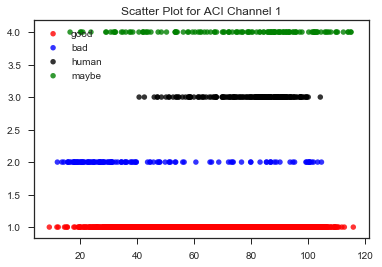

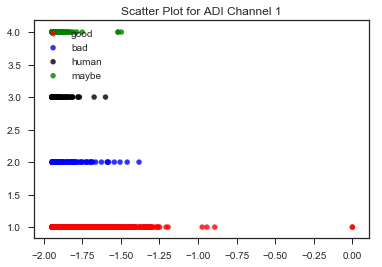

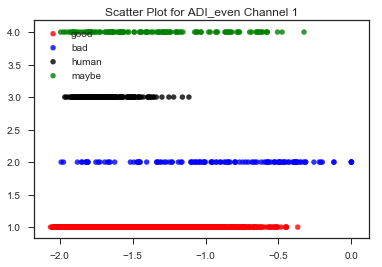

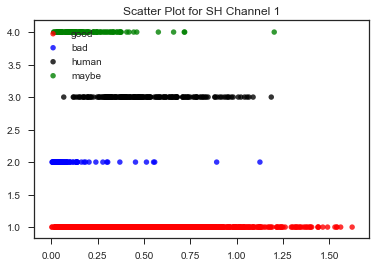

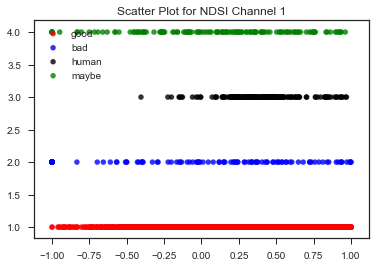

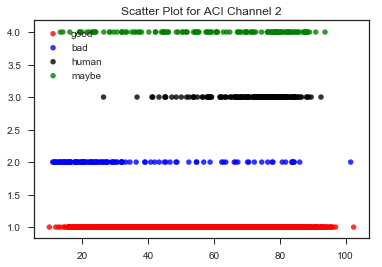

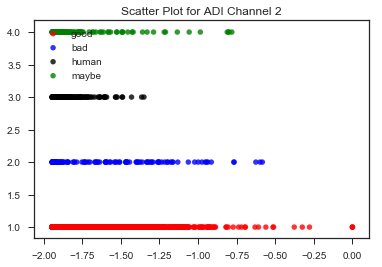

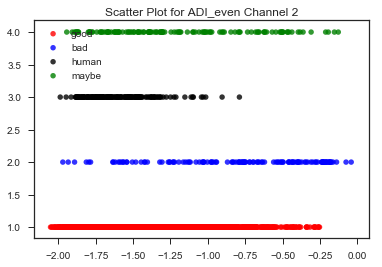

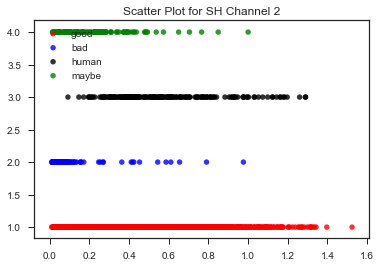

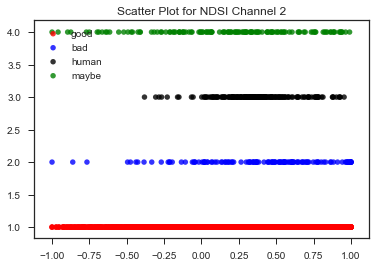

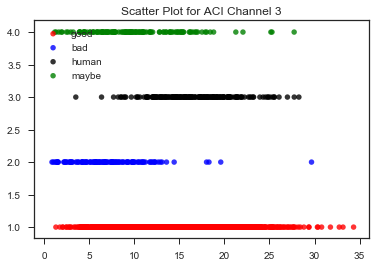

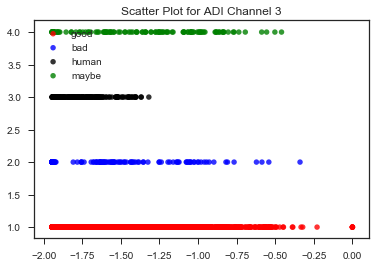

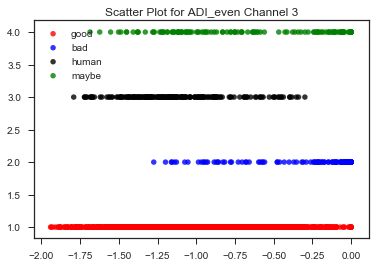

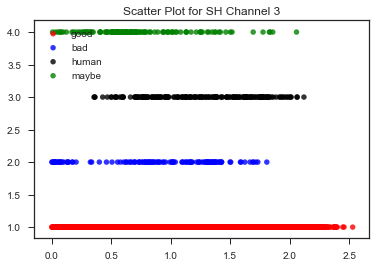

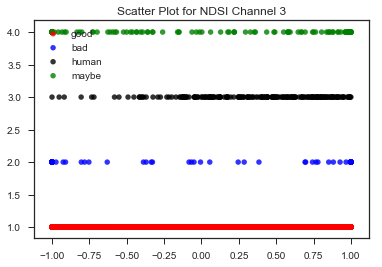

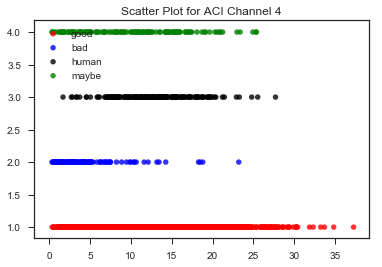

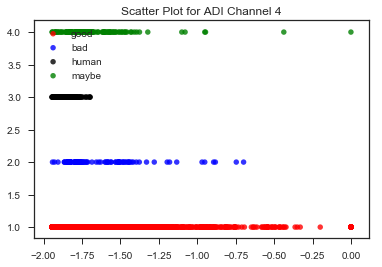

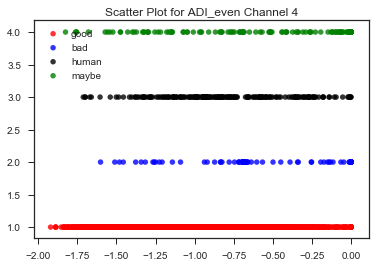

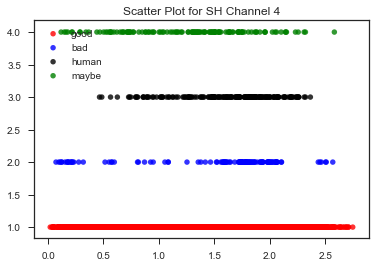

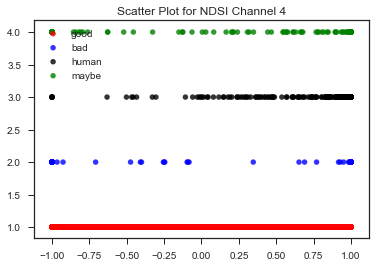

In [126]:
#Display    
plt.show()


In [127]:
#Seaborn for visualizations
import seaborn as sns
sns.set(style="ticks")

In [128]:
#General procedure to get pandas dataframes: 
#(1)reshape the array
#(2) create a dataframe with columns as acoustic indices
#(3) add an extra column with class name

def convert_df(ind1, ind2, ind3, ind4, ind5, num_specs, class_type, ch):
    ind1 = np.reshape(ind1, (num_specs, ))
    ind2 = np.reshape(ind2, (num_specs, ))
    ind3 = np.reshape(ind3, (num_specs, ))
    ind4 = np.reshape(ind4, (num_specs, ))
    ind5 = np.reshape(ind5, (num_specs, ))
    
    Class = class_type

    data = pd.DataFrame({'ACI': ind1, 'ADI': ind2, 'ADI_even': ind3, 'SH': ind4,'NDSI': ind5, 'Class': Class}, columns=['ACI', 'ADI', 'ADI_even', 'SH', 'NDSI', 'Class'])
    #print(data.shape)
    #data.head()
    
    #Removing entire rows where any one column value is NaN
    new_data = data[pd.notnull(data['ACI'])]
    new_data = new_data[pd.notnull(new_data['ADI'])]
    new_data = new_data[pd.notnull(new_data['ADI_even'])]
    new_data = new_data[pd.notnull(new_data['SH'])]
    new_data = new_data[pd.notnull(new_data['NDSI'])]
      
    #renaming the columns of the dataframe 'data' to be used while combining not NaN rows later
    data.rename(columns={'ACI': 'ACI'+str(ch), 'ADI': 'ADI'+str(ch), 'ADI_even': 'ADI_even'+str(ch), 'SH': 'SH'+str(ch), 'NDSI': 'NDSI'+str(ch)}, inplace=True)
 
    return data, new_data

In [129]:
def get_df_and_plot(ch, ACI_G, ADI_G, ADI_even_G, SH_G, NDSI_G, num_specs_g, ACI_B, ADI_B, ADI_even_B, SH_B, NDSI_B, num_specs_b, ACI_H, ADI_H, ADI_even_H, SH_H, NDSI_H, num_specs_h, ACI_M, ADI_M, ADI_even_M, SH_M, NDSI_M, num_specs_m):


    #Converting to dataframes 
    data_G_orig, data_G = convert_df(ACI_G, ADI_G, ADI_even_G, SH_G, NDSI_G, num_specs_g, 'Good', ch)
    data_B_orig, data_B = convert_df(ACI_B, ADI_B, ADI_even_B, SH_B, NDSI_B, num_specs_b, 'Bad', ch)
    data_H_orig, data_H = convert_df(ACI_H, ADI_H, ADI_even_H, SH_H, NDSI_H, num_specs_h, 'Human', ch)
    data_M_orig, data_M = convert_df(ACI_M, ADI_M, ADI_even_M, SH_M, NDSI_M, num_specs_m, 'Maybe', ch)
    
    #Scatterplot matrix for all 4 classes
    all_data_arr = [data_G, data_B, data_H, data_M]
    all_data_df = pd.concat(all_data_arr)

    print(all_data_df.shape)
    #all_data_df.head(3)
    
    sns.pairplot(all_data_df, hue="Class")
    plt.show()
    
    #Scatterplot matrix for good and bad only
    gb_data_arr = [data_G, data_B]
    gb_data_df = pd.concat(gb_data_arr)

    print(gb_data_df.shape)
    #gb_data_df.head()

    sns.pairplot(gb_data_df, hue="Class")
    plt.show()
    
    return all_data_df, gb_data_df
    
    

(3416, 6)


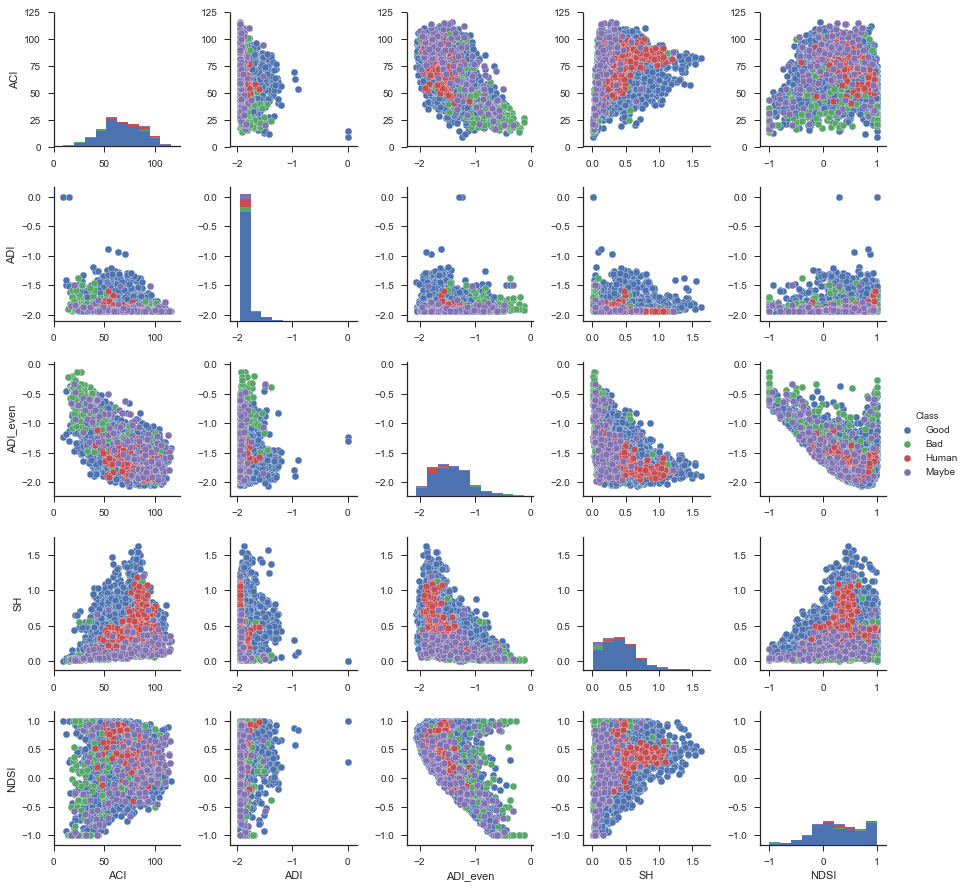

(3080, 6)


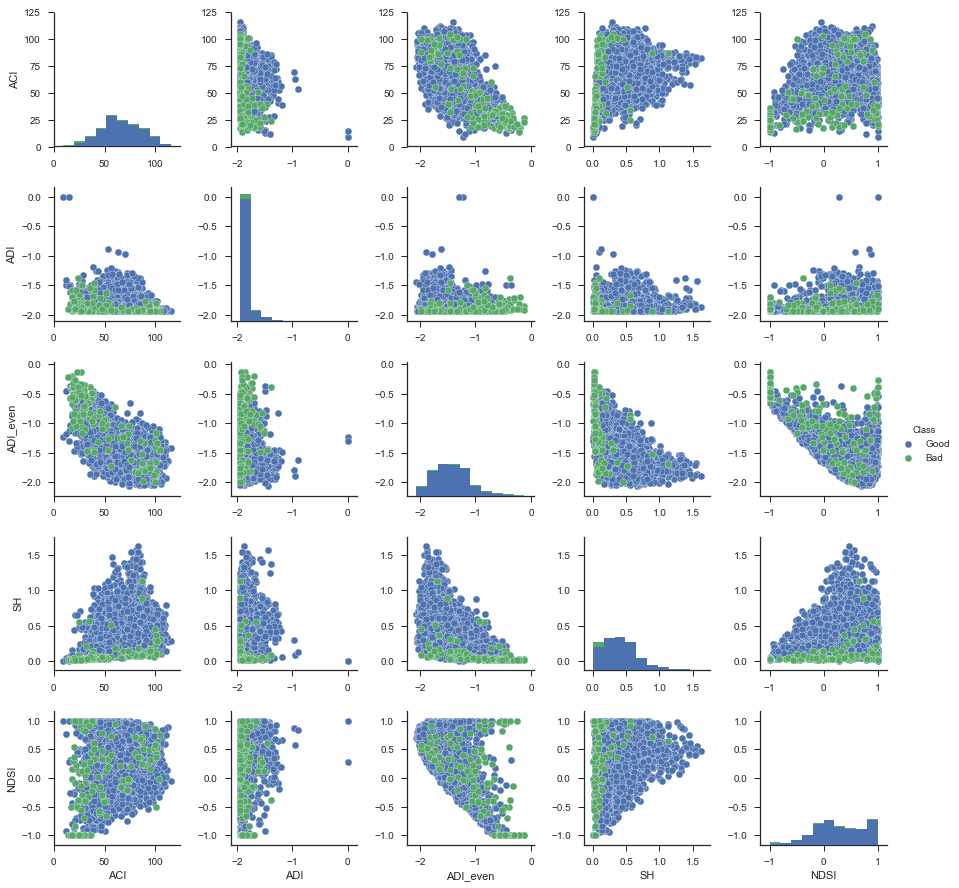

In [130]:
all_data_df1, gb_data_df1 = get_df_and_plot(1, ACI_G1, ADI_G1, ADI_even_G1, SH_G1, NDSI_G1, num_specs_g, ACI_B1, ADI_B1, ADI_even_B1, SH_B1, NDSI_B1, num_specs_b, ACI_H1, ADI_H1, ADI_even_H1, SH_H1, NDSI_H1, num_specs_h, ACI_M1, ADI_M1, ADI_even_M1, SH_M1, NDSI_M1, num_specs_m)


(3419, 6)


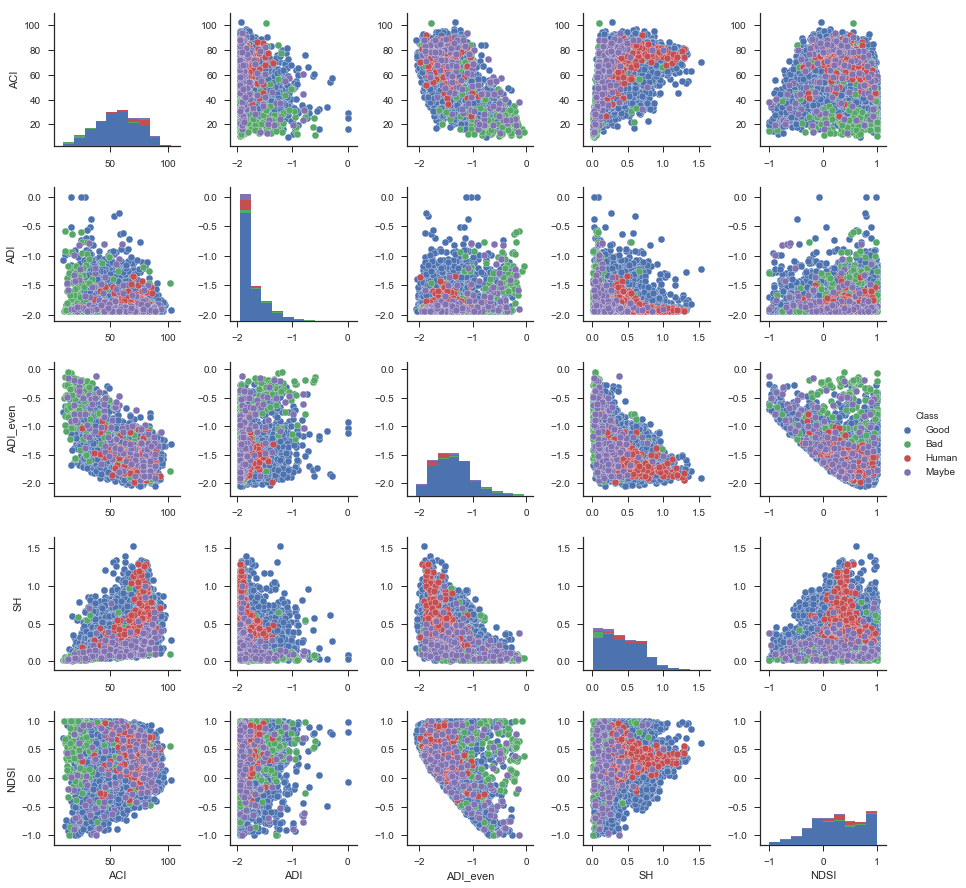

(3083, 6)


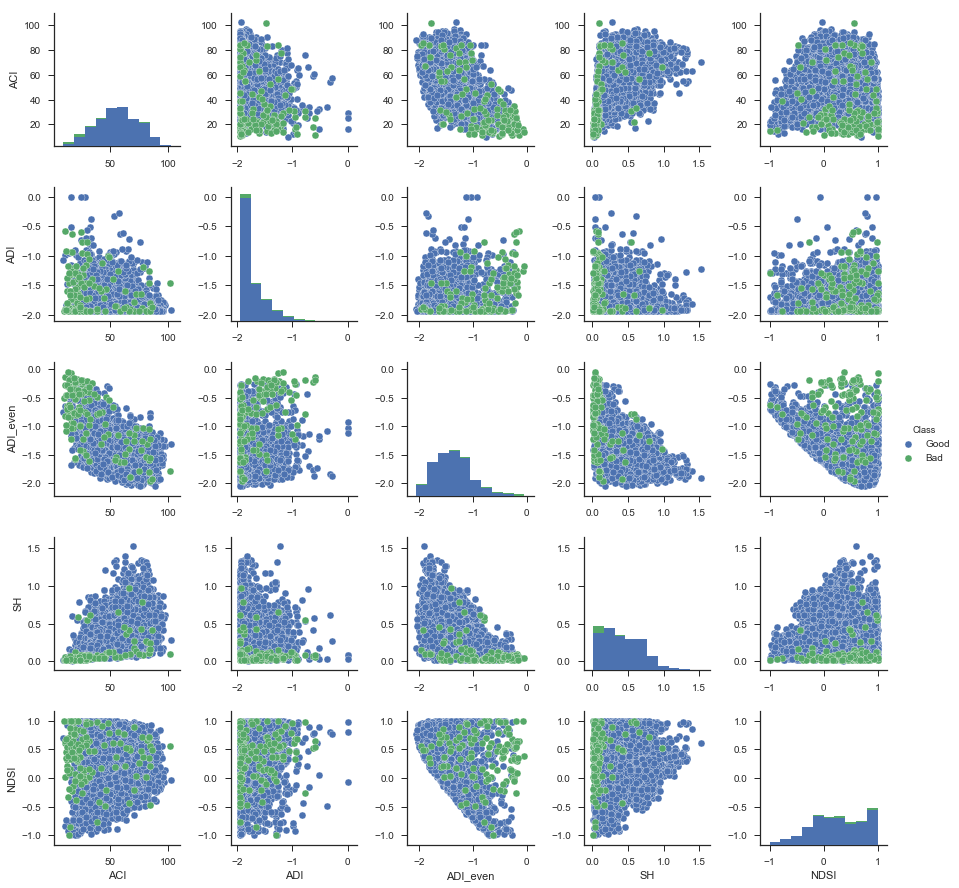

In [131]:
all_data_df2, gb_data_df2 = get_df_and_plot(2, ACI_G2, ADI_G2, ADI_even_G2, SH_G2, NDSI_G2, num_specs_g, ACI_B2, ADI_B2, ADI_even_B2, SH_B2, NDSI_B2, num_specs_b, ACI_H2, ADI_H2, ADI_even_H2, SH_H2, NDSI_H2, num_specs_h, ACI_M2, ADI_M2, ADI_even_M2, SH_M2, NDSI_M2, num_specs_m)


(3357, 6)


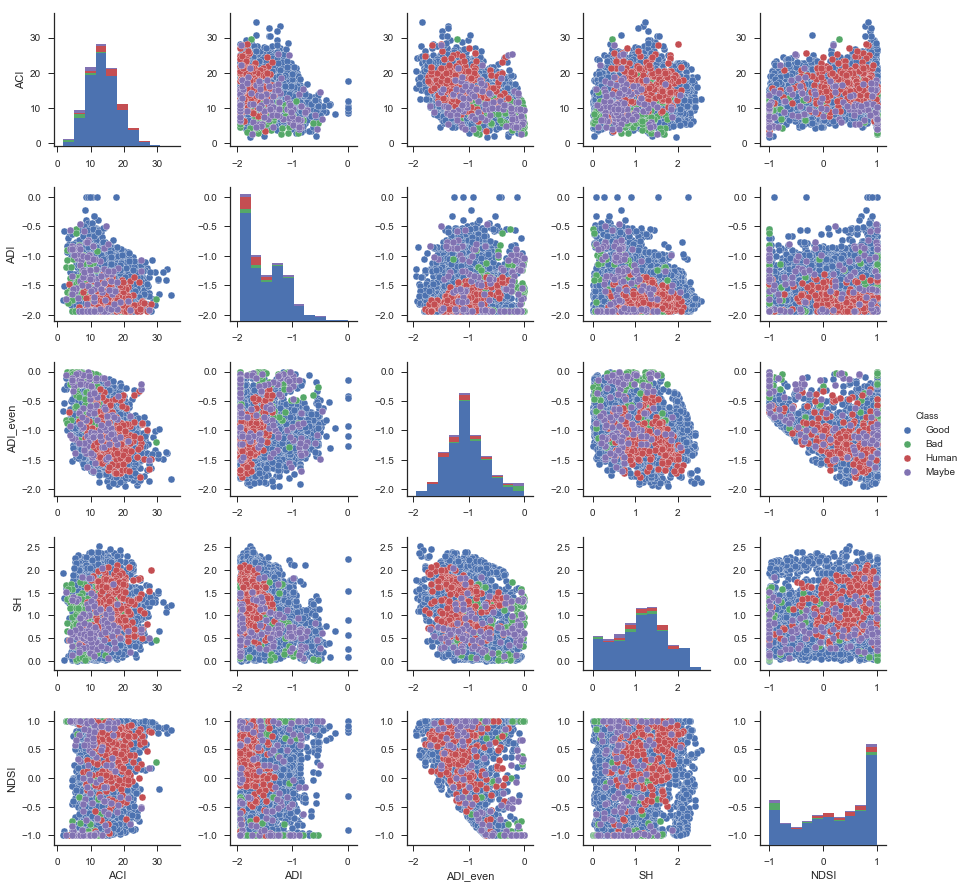

(3040, 6)


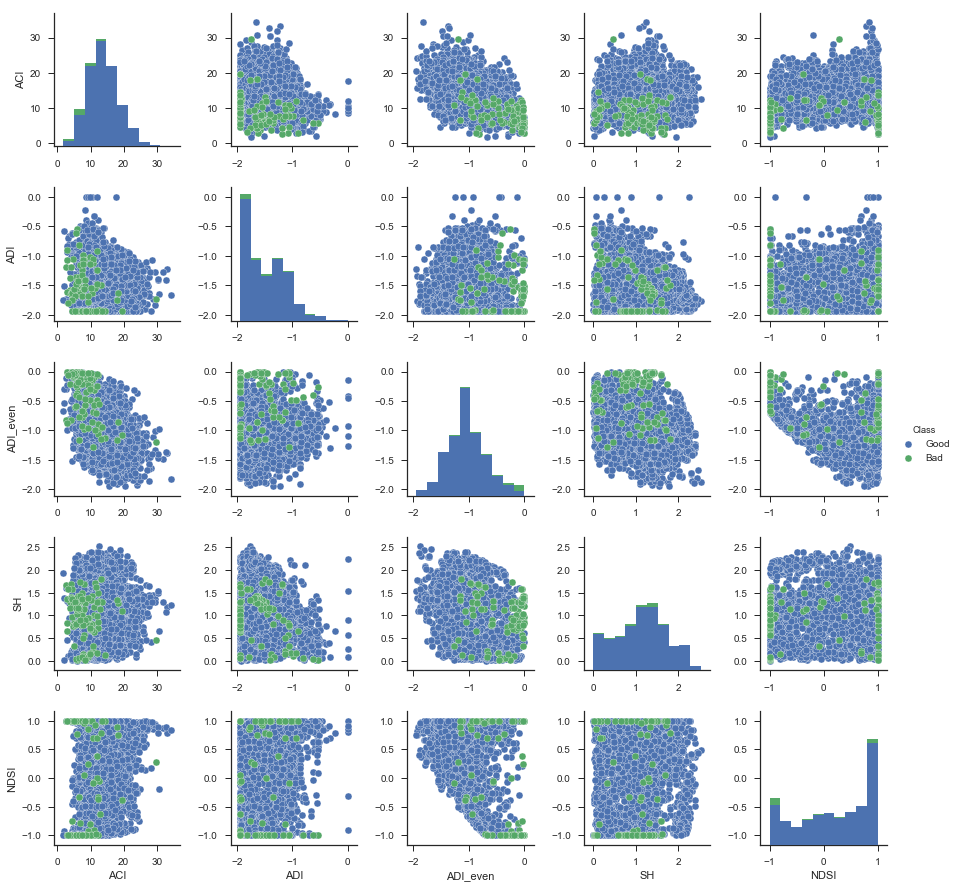

In [132]:
all_data_df3, gb_data_df3 = get_df_and_plot(3, ACI_G3, ADI_G3, ADI_even_G3, SH_G3, NDSI_G3, num_specs_g, ACI_B3, ADI_B3, ADI_even_B3, SH_B3, NDSI_B3, num_specs_b, ACI_H3, ADI_H3, ADI_even_H3, SH_H3, NDSI_H3, num_specs_h, ACI_M3, ADI_M3, ADI_even_M3, SH_M3, NDSI_M3, num_specs_m)

(3246, 6)


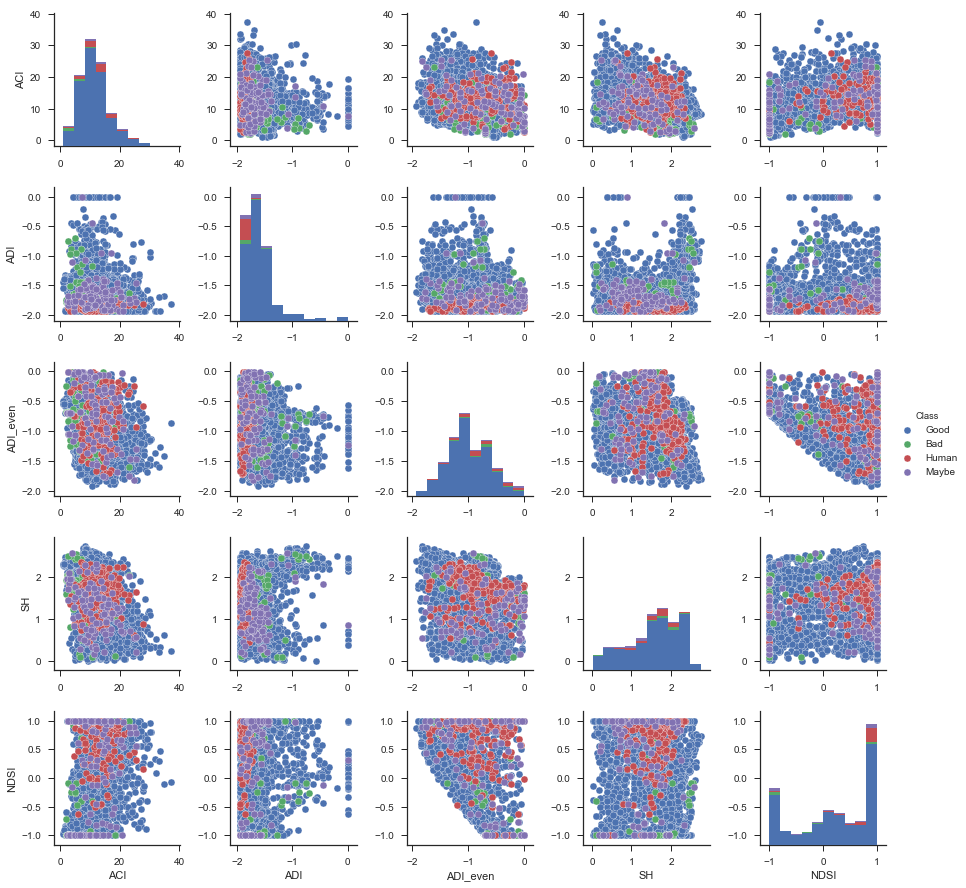

(2939, 6)


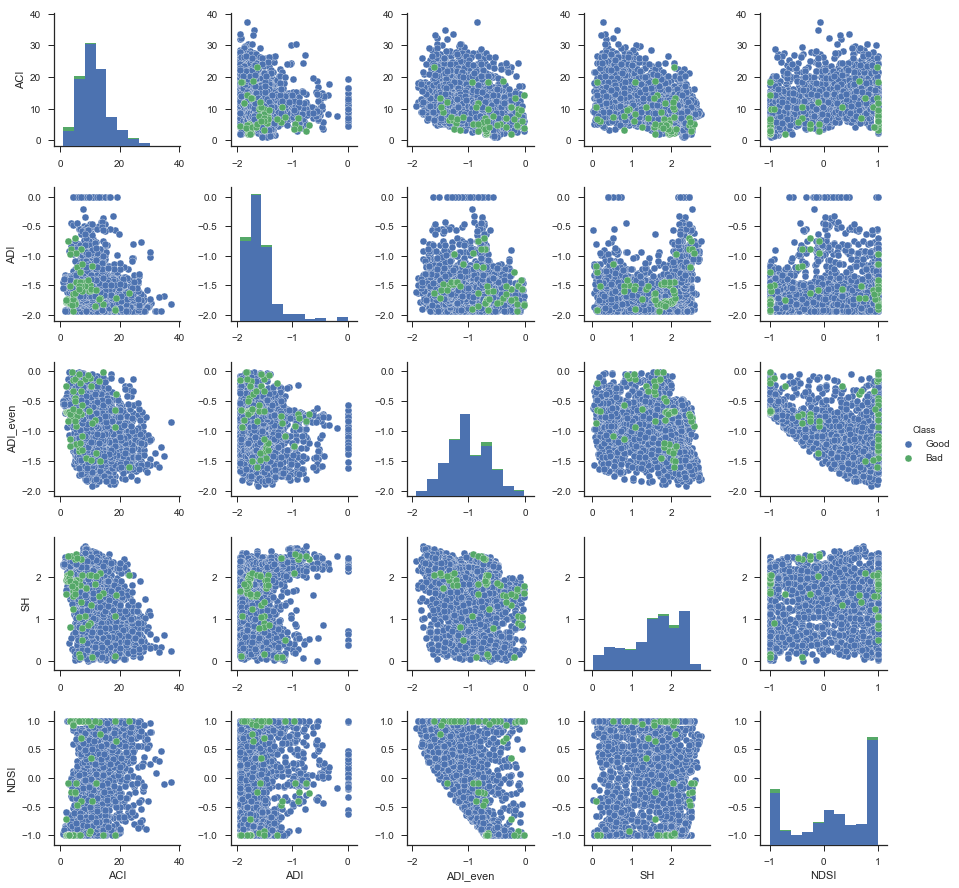

In [133]:
all_data_df4, gb_data_df4 = get_df_and_plot(4, ACI_G4, ADI_G4, ADI_even_G4, SH_G4, NDSI_G4, num_specs_g, ACI_B4, ADI_B4, ADI_even_B4, SH_B4, NDSI_B4, num_specs_b, ACI_H4, ADI_H4, ADI_even_H4, SH_H4, NDSI_H4, num_specs_h, ACI_M4, ADI_M4, ADI_even_M4, SH_M4, NDSI_M4, num_specs_m)


In [134]:
#Combining all 4 channels in a way that any NaN rows are removed
all_channel_arr = [all_data_df1, all_data_df2, all_data_df3, all_data_df4]
all_channel_df = pd.concat(all_channel_arr)

print(all_channel_df.shape)
#all_data_df.head(3)

#removing NaN values
all_channel_df_noNaN = all_channel_df[pd.notnull(all_channel_df['ACI1'])]
all_channel_df_noNaN = all_channel_df_noNaN[pd.notnull(all_channel_df_noNaN['ADI1'])]
all_channel_df_noNaN = all_channel_df_noNaN[pd.notnull(all_channel_df_noNaN['ADI_even1'])]
all_channel_df_noNaN = all_channel_df_noNaN[pd.notnull(all_channel_df_noNaN['SH1'])]
all_channel_df_noNaN = all_channel_df_noNaN[pd.notnull(all_channel_df_noNaN['NDSI1'])]

all_channel_df_noNaN = all_channel_df_noNaN[pd.notnull(all_channel_df_noNaN['ACI2'])]
all_channel_df_noNaN = all_channel_df_noNaN[pd.notnull(all_channel_df_noNaN['ADI2'])]
all_channel_df_noNaN = all_channel_df_noNaN[pd.notnull(all_channel_df_noNaN['ADI_even2'])]
all_channel_df_noNaN = all_channel_df_noNaN[pd.notnull(all_channel_df_noNaN['SH2'])]
all_channel_df_noNaN = all_channel_df_noNaN[pd.notnull(all_channel_df_noNaN['NDSI2'])]

all_channel_df_noNaN = all_channel_df_noNaN[pd.notnull(all_channel_df_noNaN['ACI3'])]
all_channel_df_noNaN = all_channel_df_noNaN[pd.notnull(all_channel_df_noNaN['ADI3'])]
all_channel_df_noNaN = all_channel_df_noNaN[pd.notnull(all_channel_df_noNaN['ADI_even3'])]
all_channel_df_noNaN = all_channel_df_noNaN[pd.notnull(all_channel_df_noNaN['SH3'])]
all_channel_df_noNaN = all_channel_df_noNaN[pd.notnull(all_channel_df_noNaN['NDSI3'])]

all_channel_df_noNaN = all_channel_df_noNaN[pd.notnull(all_channel_df_noNaN['ACI4'])]
all_channel_df_noNaN = all_channel_df_noNaN[pd.notnull(all_channel_df_noNaN['ADI4'])]
all_channel_df_noNaN = all_channel_df_noNaN[pd.notnull(all_channel_df_noNaN['ADI_even4'])]
all_channel_df_noNaN = all_channel_df_noNaN[pd.notnull(all_channel_df_noNaN['SH4'])]
all_channel_df_noNaN = all_channel_df_noNaN[pd.notnull(all_channel_df_noNaN['NDSI4'])]
      
#doing the same for just good-bad data
good_bad_arr = [gb_data_df1, gb_data_df2, gb_data_df3, gb_data_df4]
good_bad_df = pd.concat(good_bad_arr)

print(good_bad_df.shape)

good_bad_df_noNaN = good_bad_df[pd.notnull(good_bad_df['ACI1'])]
good_bad_df_noNaN = good_bad_df_noNaN[pd.notnull(good_bad_df_noNaN['ADI1'])]
good_bad_df_noNaN = good_bad_df_noNaN[pd.notnull(good_bad_df_noNaN['ADI_even1'])]
good_bad_df_noNaN = good_bad_df_noNaN[pd.notnull(good_bad_df_noNaN['SH1'])]
good_bad_df_noNaN = good_bad_df_noNaN[pd.notnull(good_bad_df_noNaN['NDSI1'])]

good_bad_df_noNaN = good_bad_df_noNaN[pd.notnull(good_bad_df_noNaN['ACI2'])]
good_bad_df_noNaN = good_bad_df_noNaN[pd.notnull(good_bad_df_noNaN['ADI2'])]
good_bad_df_noNaN = good_bad_df_noNaN[pd.notnull(good_bad_df_noNaN['ADI_even2'])]
good_bad_df_noNaN = good_bad_df_noNaN[pd.notnull(good_bad_df_noNaN['SH2'])]
good_bad_df_noNaN = good_bad_df_noNaN[pd.notnull(good_bad_df_noNaN['NDSI2'])]

good_bad_df_noNaN = good_bad_df_noNaN[pd.notnull(good_bad_df_noNaN['ACI3'])]
good_bad_df_noNaN = good_bad_df_noNaN[pd.notnull(good_bad_df_noNaN['ADI3'])]
good_bad_df_noNaN = good_bad_df_noNaN[pd.notnull(good_bad_df_noNaN['ADI_even3'])]
good_bad_df_noNaN = good_bad_df_noNaN[pd.notnull(good_bad_df_noNaN['SH3'])]
good_bad_df_noNaN = good_bad_df_noNaN[pd.notnull(good_bad_df_noNaN['NDSI3'])]

good_bad_df_noNaN = good_bad_df_noNaN[pd.notnull(good_bad_df_noNaN['ACI4'])]
good_bad_df_noNaN = good_bad_df_noNaN[pd.notnull(good_bad_df_noNaN['ADI4'])]
good_bad_df_noNaN = good_bad_df_noNaN[pd.notnull(good_bad_df_noNaN['ADI_even4'])]
good_bad_df_noNaN = good_bad_df_noNaN[pd.notnull(good_bad_df_noNaN['SH4'])]
good_bad_df_noNaN = good_bad_df_noNaN[pd.notnull(good_bad_df_noNaN['NDSI4'])]




In [ ]:
#Max function

In [ ]:
#Average function

In [ ]:
#Calling functions to combine the data - (1) Max (2) Average

#Max
max_all_df = 
max_gb_df = 

sns.pairplot(max_all_df, hue="Class")
plt.show()

sns.pairplot(max_gb_df, hue="Class")
plt.show()
  

In [ ]:
#Avg
avg_all_df = 
avg_gb_df = 

sns.pairplot(avg_all_df, hue="Class")
plt.show()

sns.pairplot(avg_gb_df, hue="Class")
plt.show()